In [1]:
from utils import lr_finder, learner, validate, MyIterator
from get_dataset import get_dataset
import random
import time
import os
from functools import partial
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR
from importlib import reload

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# If you have dark theme
from matplotlib.pyplot import rcParams
rcParams['figure.facecolor'] = 'white'

In [3]:
# Setup logger
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s : %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

In [4]:
dataset, emb_weights = get_dataset()
# dataset.fields['review'].include_lengths = True

random.seed(43)
ds_train, ds_val, ds_test = dataset.split(split_ratio=[0.8, 0.1, 0.1], random_state=random.getstate())

05/11/2020 11:59:17 PM INFO : Downloading data
05/11/2020 11:59:18 PM INFO : Downloading GloVe word vectors
05/11/2020 11:59:18 PM INFO : Loading vectors from .vector_cache/glove.6B.300d.txt.pt
05/11/2020 11:59:23 PM INFO : Loading vectors from .vector_cache/glove.6B.300d.txt.pt


In [5]:
class CNN(nn.Module):
    def __init__(self, out_channels, kernel_heights, stride, padding, dropout, emb_weights):
        super().__init__()

        self.out_channels = out_channels
        self.kernel_heights = kernel_heights
        self.stride = stride
        self.padding = padding
        self.embedding_length = emb_weights.shape[1]

        self.word_embeddings = nn.Embedding.from_pretrained(emb_weights)
        self.conv1 = nn.Conv2d(1, out_channels, (kernel_heights[0], self.embedding_length), stride, (padding[0], 0))
        self.conv2 = nn.Conv2d(1, out_channels, (kernel_heights[1], self.embedding_length), stride, (padding[1], 0))
        self.conv3 = nn.Conv2d(1, out_channels, (kernel_heights[2], self.embedding_length), stride, (padding[2], 0))
        # self.conv4 = nn.Conv2d(1, out_channels, (kernel_heights[3], self.embedding_length), stride, (padding[3], 0))
        self.dropout0 = nn.Dropout(p=dropout[0])
        self.dropout1 = nn.Dropout(p=dropout[1])
        self.relu = nn.ReLU()
        self.head = nn.Linear(len(kernel_heights)*out_channels, 2)

    def conv_block(self, input, conv_layer):
        conv_out = conv_layer(input)# conv_out.size() = (batch_size, out_channels, dim, 1)
        activation = self.relu(conv_out.squeeze(3))# activation.size() = (batch_size, out_channels, dim1)
        max_out = nn.functional.max_pool1d(activation, activation.size()[2]).squeeze(2)# maxpool_out.size() = (batch_size, out_channels)

        return max_out

    def forward(self, batch):
        input = self.word_embeddings(batch).unsqueeze(1)

        max_out = []
        max_out.append(self.conv_block(self.dropout0(input), self.conv1))
        max_out.append(self.conv_block(self.dropout0(input), self.conv2))
        max_out.append(self.conv_block(self.dropout0(input), self.conv3))

        all_out = torch.cat(max_out, dim=1)

        return self.head(self.dropout1(all_out))

In [17]:
model = CNN(out_channels=16, kernel_heights=(1, 3, 5), stride=1, padding=(0, 1, 2), dropout=(0.3, 0.3), emb_weights=emb_weights.clone())
loss_fn = nn.CrossEntropyLoss().to(device)
scheduler_fn = partial(OneCycleLR, pct_start=0.3, max_lr=5e-4, steps_per_epoch=len(ds_train)//8, epochs=1)

Finding learning rate ...100%

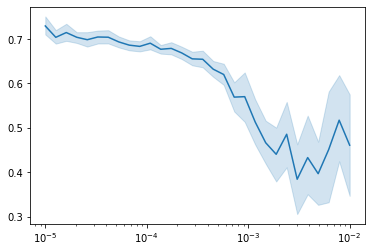

In [7]:
optimiser = Adam(model.parameters())
lr_finder(model, ds_train, optimiser, loss_fn, lr_range=[1e-5, 1e-2], bs=8, avg_over_batches=30)

In [18]:
optimiser = Adam(model.parameters())
learner(model, loss_fn, optimiser, ds_train, ds_val, epochs=5, bs=8, scheduler_fn=scheduler_fn)

05/12/2020 12:07:27 AM INFO : Epoch : 1, batch : 100, train_loss = 0.6909, val_loss = 0.6709, val_accuracy : 0.503, time = 1s
05/12/2020 12:07:28 AM INFO : Epoch : 1, batch : 200, train_loss = 0.6215, val_loss = 0.5855, val_accuracy : 0.783, time = 1s
05/12/2020 12:07:29 AM INFO : Epoch : 1, batch : 300, train_loss = 0.5887, val_loss = 0.5680, val_accuracy : 0.797, time = 2s
05/12/2020 12:07:29 AM INFO : Epoch : 2, batch : 100, train_loss = 0.5577, val_loss = 0.5361, val_accuracy : 0.737, time = 2s
05/12/2020 12:07:30 AM INFO : Epoch : 2, batch : 200, train_loss = 0.4810, val_loss = 0.4576, val_accuracy : 0.820, time = 3s
05/12/2020 12:07:31 AM INFO : Epoch : 2, batch : 300, train_loss = 0.4784, val_loss = 0.4466, val_accuracy : 0.830, time = 4s
05/12/2020 12:07:31 AM INFO : Epoch : 3, batch : 100, train_loss = 0.4478, val_loss = 0.4333, val_accuracy : 0.827, time = 4s
05/12/2020 12:07:32 AM INFO : Epoch : 3, batch : 200, train_loss = 0.3830, val_loss = 0.3864, val_accuracy : 0.860, ti

In [19]:
scheduler_fn = partial(OneCycleLR, pct_start=0.1, max_lr=1e-4, steps_per_epoch=len(ds_train)//8, epochs=1)
learner(model, loss_fn, optimiser, ds_train, ds_val, epochs=3, bs=8, scheduler_fn=scheduler_fn)

05/12/2020 12:08:27 AM INFO : Epoch : 1, batch : 100, train_loss = 0.3183, val_loss = 0.3324, val_accuracy : 0.883, time = 1s
05/12/2020 12:08:27 AM INFO : Epoch : 1, batch : 200, train_loss = 0.2606, val_loss = 0.3293, val_accuracy : 0.887, time = 1s
05/12/2020 12:08:28 AM INFO : Epoch : 1, batch : 300, train_loss = 0.3606, val_loss = 0.3292, val_accuracy : 0.880, time = 2s
05/12/2020 12:08:29 AM INFO : Epoch : 2, batch : 100, train_loss = 0.2909, val_loss = 0.3280, val_accuracy : 0.887, time = 2s
05/12/2020 12:08:29 AM INFO : Epoch : 2, batch : 200, train_loss = 0.2529, val_loss = 0.3274, val_accuracy : 0.880, time = 3s
05/12/2020 12:08:30 AM INFO : Epoch : 2, batch : 300, train_loss = 0.3585, val_loss = 0.3273, val_accuracy : 0.880, time = 4s
05/12/2020 12:08:30 AM INFO : Epoch : 3, batch : 100, train_loss = 0.2982, val_loss = 0.3260, val_accuracy : 0.890, time = 4s
05/12/2020 12:08:31 AM INFO : Epoch : 3, batch : 200, train_loss = 0.2492, val_loss = 0.3246, val_accuracy : 0.883, ti

In [20]:
model.word_embeddings.weight.requires_grad_(True);
scheduler_fn = partial(OneCycleLR, pct_start=0.1, max_lr=1e-4, steps_per_epoch=len(ds_train)//8, epochs=1)
learner(model, loss_fn, optimiser, ds_train, ds_val, epochs=3, bs=8, scheduler_fn=scheduler_fn)

05/12/2020 12:08:47 AM INFO : Epoch : 1, batch : 100, train_loss = 0.2888, val_loss = 0.3225, val_accuracy : 0.893, time = 2s
05/12/2020 12:08:49 AM INFO : Epoch : 1, batch : 200, train_loss = 0.2398, val_loss = 0.3201, val_accuracy : 0.880, time = 4s
05/12/2020 12:08:50 AM INFO : Epoch : 1, batch : 300, train_loss = 0.3443, val_loss = 0.3201, val_accuracy : 0.883, time = 5s
05/12/2020 12:08:52 AM INFO : Epoch : 2, batch : 100, train_loss = 0.2664, val_loss = 0.3184, val_accuracy : 0.893, time = 7s
05/12/2020 12:08:54 AM INFO : Epoch : 2, batch : 200, train_loss = 0.2294, val_loss = 0.3156, val_accuracy : 0.890, time = 9s
05/12/2020 12:08:56 AM INFO : Epoch : 2, batch : 300, train_loss = 0.3373, val_loss = 0.3155, val_accuracy : 0.890, time = 11s
05/12/2020 12:08:58 AM INFO : Epoch : 3, batch : 100, train_loss = 0.2642, val_loss = 0.3127, val_accuracy : 0.887, time = 13s
05/12/2020 12:09:00 AM INFO : Epoch : 3, batch : 200, train_loss = 0.2139, val_loss = 0.3111, val_accuracy : 0.890, 

In [21]:
model.word_embeddings.weight.requires_grad_(True);
scheduler_fn = partial(OneCycleLR, pct_start=0.1, max_lr=3e-5, steps_per_epoch=len(ds_train)//8, epochs=1)
learner(model, loss_fn, optimiser, ds_train, ds_val, epochs=3, bs=8, scheduler_fn=scheduler_fn)

05/12/2020 12:09:16 AM INFO : Epoch : 1, batch : 100, train_loss = 0.2399, val_loss = 0.3096, val_accuracy : 0.890, time = 2s
05/12/2020 12:09:18 AM INFO : Epoch : 1, batch : 200, train_loss = 0.2162, val_loss = 0.3094, val_accuracy : 0.890, time = 3s
05/12/2020 12:09:19 AM INFO : Epoch : 1, batch : 300, train_loss = 0.3339, val_loss = 0.3095, val_accuracy : 0.890, time = 5s
05/12/2020 12:09:21 AM INFO : Epoch : 2, batch : 100, train_loss = 0.2427, val_loss = 0.3082, val_accuracy : 0.890, time = 7s
05/12/2020 12:09:23 AM INFO : Epoch : 2, batch : 200, train_loss = 0.2058, val_loss = 0.3078, val_accuracy : 0.890, time = 9s
05/12/2020 12:09:25 AM INFO : Epoch : 2, batch : 300, train_loss = 0.3251, val_loss = 0.3078, val_accuracy : 0.890, time = 11s
05/12/2020 12:09:27 AM INFO : Epoch : 3, batch : 100, train_loss = 0.2493, val_loss = 0.3068, val_accuracy : 0.890, time = 13s
05/12/2020 12:09:29 AM INFO : Epoch : 3, batch : 200, train_loss = 0.2216, val_loss = 0.3066, val_accuracy : 0.890, 

In [22]:
print('Test loss : {:.5f}, test accuracy : {:.03f}'.format(*validate(ds_test, loss_fn, model)))

Test loss : 0.27225, test accuracy : 0.903


<br>

In [23]:
class CNN2(nn.Module):
    def __init__(self, out_channels, kernel_heights, stride, padding, dropout, emb_weights):
        super().__init__()
        
        self.out_channels = out_channels
        self.kernel_heights = kernel_heights
        self.stride = stride
        self.padding = padding
        self.embedding_length = emb_weights.shape[1]

        self.word_embeddings = nn.Embedding.from_pretrained(emb_weights)
        self.conv1 = nn.Conv2d(1, out_channels, (kernel_heights[0], self.embedding_length), stride, (padding[0], 0))
        self.conv2 = nn.Conv2d(out_channels, 2*out_channels, (kernel_heights[1], 1), stride, (padding[1], 0))
        self.conv3 = nn.Conv2d(2*out_channels, 4*out_channels, (kernel_heights[2], 1), stride, (padding[2], 0))
        self.dropout0 = nn.Dropout(p=dropout[0])
        self.dropout1 = nn.Dropout(p=dropout[1])
        self.relu = nn.ReLU()
        self.head = nn.Linear(4*out_channels, 2)

    def forward(self, batch):
        input = self.word_embeddings(batch).unsqueeze(1)
        # input.size() = (batch_size, 1, num_seq, embedding_length)
        
        out = self.relu(self.conv1(self.dropout0(input)))
        out = self.relu(self.conv2(self.dropout0(out)))
        out = self.relu(self.conv3(self.dropout0(out)))
        max_out = max_out = nn.functional.max_pool1d(out.squeeze(3), out.size()[2]).squeeze(2)

        return self.head(self.dropout1(max_out))

In [30]:
model = CNN2(out_channels=32, kernel_heights=(1, 3, 5), stride=1, padding=(0, 1, 2), dropout=(0.3, 0.3), emb_weights=emb_weights.clone())
loss_fn = nn.CrossEntropyLoss().to(device)
optimiser = Adam(model.parameters())

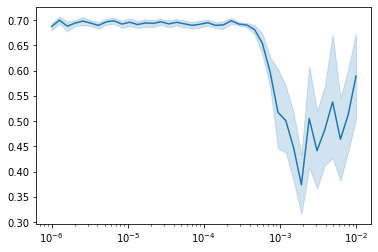

In [304]:
optimiser = Adam(model.parameters())
lr_finder(model, ds_train, optimiser, loss_fn, lr_range=[1e-6, 1e-2], bs=8, avg_over_batches=30)

In [31]:
scheduler_fn = partial(OneCycleLR, pct_start=0.3, max_lr=5e-4, steps_per_epoch=len(ds_train)//8, epochs=1)
learner(model, loss_fn, optimiser, ds_train, ds_val, epochs=3, bs=8)

05/12/2020 12:44:31 AM INFO : Epoch : 1, batch : 100, train_loss = 0.6902, val_loss = 0.6912, val_accuracy : 0.473, time = 1s
05/12/2020 12:44:32 AM INFO : Epoch : 1, batch : 200, train_loss = 0.5485, val_loss = 0.3868, val_accuracy : 0.823, time = 2s
05/12/2020 12:44:33 AM INFO : Epoch : 1, batch : 300, train_loss = 0.4455, val_loss = 0.3525, val_accuracy : 0.853, time = 3s
05/12/2020 12:44:34 AM INFO : Epoch : 2, batch : 100, train_loss = 0.4318, val_loss = 0.3577, val_accuracy : 0.857, time = 4s
05/12/2020 12:44:35 AM INFO : Epoch : 2, batch : 200, train_loss = 0.3555, val_loss = 0.3251, val_accuracy : 0.870, time = 5s
05/12/2020 12:44:36 AM INFO : Epoch : 2, batch : 300, train_loss = 0.4070, val_loss = 0.3120, val_accuracy : 0.863, time = 6s
05/12/2020 12:44:36 AM INFO : Epoch : 3, batch : 100, train_loss = 0.3715, val_loss = 0.3123, val_accuracy : 0.883, time = 7s
05/12/2020 12:44:37 AM INFO : Epoch : 3, batch : 200, train_loss = 0.3334, val_loss = 0.2982, val_accuracy : 0.887, ti

In [32]:
scheduler_fn = partial(OneCycleLR, pct_start=0.1, max_lr=1e-4, steps_per_epoch=len(ds_train)//8, epochs=1)
learner(model, loss_fn, optimiser, ds_train, ds_val, epochs=3, bs=8)

05/12/2020 12:44:52 AM INFO : Epoch : 1, batch : 100, train_loss = 0.3586, val_loss = 0.3131, val_accuracy : 0.867, time = 1s
05/12/2020 12:44:53 AM INFO : Epoch : 1, batch : 200, train_loss = 0.3098, val_loss = 0.2933, val_accuracy : 0.890, time = 2s
05/12/2020 12:44:54 AM INFO : Epoch : 1, batch : 300, train_loss = 0.3577, val_loss = 0.3064, val_accuracy : 0.873, time = 3s
05/12/2020 12:44:55 AM INFO : Epoch : 2, batch : 100, train_loss = 0.3060, val_loss = 0.3360, val_accuracy : 0.850, time = 4s
05/12/2020 12:44:56 AM INFO : Epoch : 2, batch : 200, train_loss = 0.3199, val_loss = 0.3070, val_accuracy : 0.887, time = 5s
05/12/2020 12:44:57 AM INFO : Epoch : 2, batch : 300, train_loss = 0.3529, val_loss = 0.3249, val_accuracy : 0.863, time = 6s
05/12/2020 12:44:58 AM INFO : Epoch : 3, batch : 100, train_loss = 0.3164, val_loss = 0.3301, val_accuracy : 0.860, time = 7s
05/12/2020 12:44:59 AM INFO : Epoch : 3, batch : 200, train_loss = 0.2602, val_loss = 0.3044, val_accuracy : 0.877, ti

In [33]:
model.word_embeddings.weight.requires_grad_(True);
scheduler_fn = partial(OneCycleLR, pct_start=0.1, max_lr=1e-4, steps_per_epoch=len(ds_train)//8, epochs=1)
learner(model, loss_fn, optimiser, ds_train, ds_val, epochs=3, bs=8)

05/12/2020 12:45:14 AM INFO : Epoch : 1, batch : 100, train_loss = 0.2997, val_loss = 0.2898, val_accuracy : 0.867, time = 2s
05/12/2020 12:45:16 AM INFO : Epoch : 1, batch : 200, train_loss = 0.2573, val_loss = 0.3125, val_accuracy : 0.883, time = 4s
05/12/2020 12:45:19 AM INFO : Epoch : 1, batch : 300, train_loss = 0.3077, val_loss = 0.2992, val_accuracy : 0.883, time = 7s
05/12/2020 12:45:21 AM INFO : Epoch : 2, batch : 100, train_loss = 0.2437, val_loss = 0.2922, val_accuracy : 0.877, time = 9s
05/12/2020 12:45:23 AM INFO : Epoch : 2, batch : 200, train_loss = 0.2115, val_loss = 0.2895, val_accuracy : 0.887, time = 12s
05/12/2020 12:45:26 AM INFO : Epoch : 2, batch : 300, train_loss = 0.2282, val_loss = 0.3014, val_accuracy : 0.887, time = 14s
05/12/2020 12:45:28 AM INFO : Epoch : 3, batch : 100, train_loss = 0.1726, val_loss = 0.2958, val_accuracy : 0.877, time = 16s
05/12/2020 12:45:31 AM INFO : Epoch : 3, batch : 200, train_loss = 0.1408, val_loss = 0.3100, val_accuracy : 0.890,

In [314]:
scheduler_fn = partial(OneCycleLR, pct_start=0.1, max_lr=1e-4, steps_per_epoch=len(ds_train)//8, epochs=1)
learner(model, loss_fn, optimiser, ds_train, ds_val, epochs=3, bs=8)

05/07/2020 04:55:03 PM INFO : Epoch : 1, batch : 100, train_loss = 0.1699, val_loss = 0.2592, val_accuracy : 0.897, time = 3s
05/07/2020 04:55:06 PM INFO : Epoch : 1, batch : 200, train_loss = 0.1545, val_loss = 0.2629, val_accuracy : 0.907, time = 5s
05/07/2020 04:55:08 PM INFO : Epoch : 1, batch : 300, train_loss = 0.1832, val_loss = 0.2586, val_accuracy : 0.900, time = 8s
05/07/2020 04:55:11 PM INFO : Epoch : 2, batch : 100, train_loss = 0.1630, val_loss = 0.2583, val_accuracy : 0.900, time = 11s
05/07/2020 04:55:13 PM INFO : Epoch : 2, batch : 200, train_loss = 0.1662, val_loss = 0.2637, val_accuracy : 0.903, time = 13s
05/07/2020 04:55:16 PM INFO : Epoch : 2, batch : 300, train_loss = 0.1874, val_loss = 0.2599, val_accuracy : 0.907, time = 16s
05/07/2020 04:55:19 PM INFO : Epoch : 3, batch : 100, train_loss = 0.1607, val_loss = 0.2581, val_accuracy : 0.900, time = 18s
05/07/2020 04:55:21 PM INFO : Epoch : 3, batch : 200, train_loss = 0.1597, val_loss = 0.2583, val_accuracy : 0.903

In [34]:
print('Test loss : {:.5f}, test accuracy : {:.03f}'.format(*validate(ds_test, loss_fn, model)))

Test loss : 0.25334, test accuracy : 0.907


<br>

### Look at some predictions

In [203]:
import numpy as np

In [299]:
def most_confused(ds, loss_fn, model, top_k=5, device=device):
    is_in_train = model.training
    model.eval()
    with torch.no_grad():
        predictions = []
        gt = []
        losses = []
        reviews = []
        for i, batch in enumerate(MyIterator(ds, 1, sort_key=lambda x: len(x.review), shuffle=False, train=False, device=device)):
            output = model(batch.review)
            predictions.extend(output.argmax(dim=1).tolist())
            gt.extend(batch.label.tolist())
            losses.append(loss_fn(output, batch.label).item())
            reviews.append(batch.review)
            
    vocab = ds.fields['review'].vocab
    preds = np.array([losses, list(range(len(reviews))), predictions, gt]).transpose()
    wrong_preds = preds[preds[:,2] != preds[:,3]]
    wrong_preds_sorted = np.array(sorted(wrong_preds[:], key=lambda x: x[0]))
    top_k_wrong = wrong_preds_sorted[:top_k,:]
    top_k_wrong = [(loss, ' '.join([vocab.itos[i] for i in reviews[int(review_id)][0].tolist()]), 'gt: {}, pred : {}'.format(gt, pred)) for (loss, review_id, pred, gt) in top_k_wrong]
    
    if is_in_train: model.train()    
    return top_k_wrong

In [301]:
most_confused(ds_val, loss_fn, model, top_k=10)

[(0.7110309600830078, "better than you 'd expect .", 'gt: 1.0, pred : 0.0'),
 (0.7474281787872314,
  'i dressed up to be treated so rudely !',
  'gt: 0.0, pred : 1.0'),
 (0.7563066482543945,
  'the only thing i did like was the prime rib and dessert section .',
  'gt: 1.0, pred : 0.0'),
 (0.7787615656852722, 'i just wanted to leave .', 'gt: 0.0, pred : 1.0'),
 (0.8162384033203125,
  'i ordered this for sony ericsson <unk> but i think it only worked once ( that s when i first used it ) .',
  'gt: 0.0, pred : 1.0'),
 (0.8669049739837646,
  'motorola finally got the voice quality of a bluetooth headset right .',
  'gt: 1.0, pred : 0.0'),
 (0.9086286425590515,
  "the best example of how dumb the writing is when it 's established that you can turn the zombie - students back into humans by removing a necklace containing a piece of the meteorite .",
  'gt: 0.0, pred : 1.0'),
 (0.979867696762085,
  'kris kristoffersen is good in this movie and really makes a difference .',
  'gt: 1.0, pred : 0